<a href="https://colab.research.google.com/github/Jack3690/INSIST_pipeline/blob/main/notebooks/MACADAMIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install insist-pista --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 53.7 MB/s eta 0:00:00


In [2]:
!pip install astrometry --quiet
!pip install astroquery --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 kB 16.4 MB/s eta 0:00:00


In [3]:
!pip install reproject --quiet
!pip install photutils --quiet

In [4]:
import pista as pt
import numpy as np
import os
import matplotlib.pyplot as plt

import matplotlib.colors as col
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.stats as stats

from astropy.modeling import models, fitting
from astroquery.mast import Catalogs
from astropy.nddata import Cutout2D

import photutils as phot
from photutils.detection import DAOStarFinder
from photutils.background import Background2D, MedianBackground
from photutils.aperture import CircularAperture, SkyCircularAnnulus, aperture_photometry

from reproject import reproject_interp, reproject_exact
from reproject.mosaicking import find_optimal_celestial_wcs

from astropy.convolution import Gaussian2DKernel, convolve_fft
from photutils.segmentation import detect_sources, deblend_sources, SourceCatalog

In [5]:
data_path = pt.data_dir

In [6]:
!git clone https://github.com/Jack3690/INSIST_pipeline --quiet

# **Input Data**

In [7]:
tab = Table.read(f'{data_path}/sample.fits')
df = tab.to_pandas()

# **Image Generation using PISTA**

In [8]:
if not os.path.exists('input_data'):
  os.mkdir('input_data')

In [113]:
tel_params = {
              'aperture'       : 100,
              'pixel_scale'    : 0.1,
              'psf_file'       : f'{data_path}/PSF/INSIST/off_axis_hcipy.npy',
              'response_funcs' :  [ f'{data_path}/INSIST/UV/Filter.dat,1,100',
                                    f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 5 mirrors
                                    f'{data_path}/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                  ],
              }

det_params = {    'shot_noise' :  'Gaussian',
                  'G1'         :  1,
                  'PRNU_frac'  :  0.25/100,
                  'qe_response': [f'{data_path}/INSIST/UV/QE.dat,1,100'],
                  'RN'         :  5,
                  'T'          :  218,
                  'DCNU'       :  0.1/100
             }

In [114]:
sim = pt.Imager(df = df,tel_params = tel_params, n_x = 400, n_y = 400,
                exp_time = 2400)

user_profiles = {'PRNU' : sim.flat_frame,
                 'Bias' : sim.bias_array,
                 'DNFP' : sim.DNFP_array}

sim(det_params = det_params, photometry = None)
cen_ra = sim.ra
cen_dec = sim.dec

flats = []
biass = []
darks = []

ts = []
for i, t in enumerate([100, 200, 300, 600, 800, 1000, 1200, 1500, 2000, 2500]):

  del_ra = 5*np.random.random(1)[0]/3600
  del_dec = 5*np.random.random(1)[0]/3600

  coords = (cen_ra + del_ra, cen_dec + del_dec)

  sim = pt.Imager(df = df, coords = coords,
                  tel_params = tel_params, n_x = 400, n_y = 400,
                  exp_time = t, user_profiles = user_profiles)
  sim( det_params = det_params, photometry = None)

  sim.writeto(f'input_data/img{i}.fits')

  flat = sim.flat_frame

  exp_time = sim.exp_time
  sim.exp_time = 0
  bias = sim.make_ccd_image(0)
  sim.exp_time = exp_time

  dark = sim.dark_frame

  flats.append(flat)
  biass.append(bias)
  darks.append(dark)
  ts.append(sim.exp_time)

(<Figure size 1500x1000 with 2 Axes>,
 <WCSAxes: title={'center': 'Digital \nRequested center :  RA : 11.07 degrees, Dec : 41.352 degrees'}>)

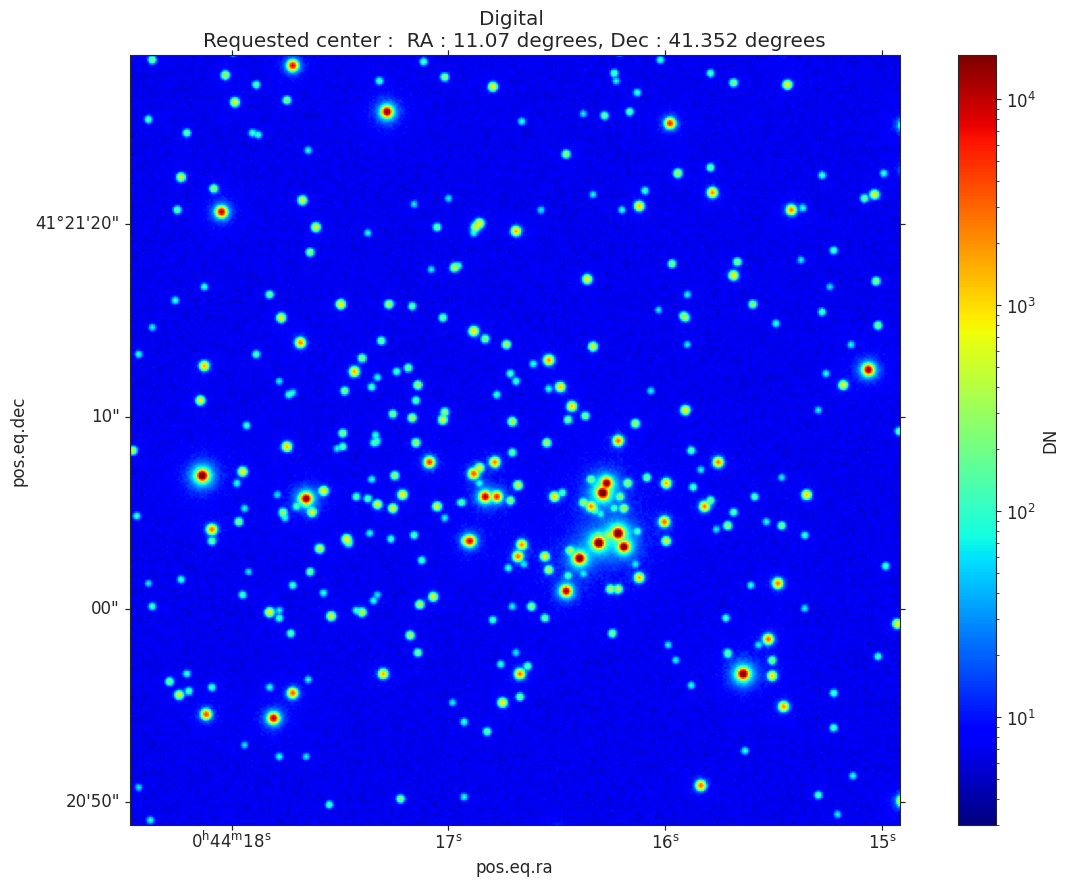

In [115]:
sim.show_image()

## **Calibration Database creation**

In [116]:
flats = np.array(flats)
biass = np.array(biass)
darks = np.array(darks)
ts    = np.array(ts).reshape(-1,1,1)

In [117]:
master_flat = np.median(flats, axis = 0)
master_bias = np.median(biass, axis = 0)
master_dark = np.median((darks - master_bias)/ts, axis = 0)

In [118]:
header = sim.header

In [119]:
header['FRAME'] = 'MASTER FLAT'
hdu = fits.PrimaryHDU(master_flat, header=header)
hdul = fits.HDUList([hdu])
hdul.writeto('/content/INSIST_pipeline/data/Cal_DB/Master_Flat.fits'
              , overwrite=True)

header['FRAME'] = 'MASTER BIAS'
hdu = fits.PrimaryHDU(master_bias, header=header)
hdul = fits.HDUList([hdu])
hdul.writeto('/content/INSIST_pipeline/data/Cal_DB/Master_Bias.fits'
              , overwrite=True)

header['FRAME'] = 'MASTER DARK'
hdu = fits.PrimaryHDU(np.abs(master_dark), header=header)
hdul = fits.HDUList([hdu])
hdul.writeto('/content/INSIST_pipeline/data/Cal_DB/Master_Dark.fits'
              , overwrite=True)

# **Pipeline**

## **Pre-processing**

In [ ]:
# TBD Distortion correction using OpenCV

## **Flux Calibration**

In [120]:
input_dir = '/content/input_data'
cal_db = '/content/INSIST_pipeline/data/Cal_DB'

dark = fits.open(f'{cal_db}/Master_Dark.fits')[0].data
bias = fits.open(f'{cal_db}/Master_Bias.fits')[0].data
flat = fits.open(f'{cal_db}/Master_Flat.fits')[0].data

out_dir = 'Out_FC'
if not os.path.exists(out_dir):
  os.mkdir(out_dir)
for f in os.listdir(input_dir):

  hdul = fits.open(f'{input_dir}/{f}')
  data = hdul[0].data

  # Dark and Bias Subtraction

  dark_e = dark*hdul[0].header['EXPTIME']
  data_DB = data - bias - dark_e

  # Flat fielding
  data_F = data_DB/flat

  data_F = np.where(data_F>0, data_F,0)

  hdul[0].data = data_F
  hdul[0].header['FRAME'] = "FLUX CALIBRATED"
  hdul[0].header['BUNIT'] ='CPS'
  hdul[0].header['ZP'] = 22.239
  hdul.writeto(f"{out_dir}/{f.split('.')[0]}_FC.fits", overwrite = True)

## **Astrometric Calibration**

In [121]:
def detect_stars(data, std=3, fwhm=3):
  sigma = 3.0*stats.gaussian_fwhm_to_sigma  # FWHM = 3.

  kernel = Gaussian2DKernel(x_stddev=sigma)

  # Estimate Background
  sigma_clip = stats.SigmaClip(sigma=std)
  bkg_estimator = MedianBackground()
  filter_size = (3, 3)
  box_size = 200
  bkg = Background2D( data,
                      box_size,
                      filter_size=filter_size,
                      sigma_clip=sigma_clip,
                      bkg_estimator=bkg_estimator)

  threshold_img = bkg.background + (std*bkg.background_rms)
  threshold = np.median(threshold_img)

  # Perform star detection
  daofind = DAOStarFinder(3*bkg.background_rms_median, fwhm)

  convolved_data = convolve_fft(data-threshold_img,kernel)

  sources = daofind(convolved_data)

  return sources

In [122]:
def get_reference_catalog(hdul, catalog='HSC', version=3):

  cen_dec = hdul[0].header['CRVAL2']

  if hdul[0].header['CRPIX1'] >= hdul[0].header['CRPIX2']:
    npix = hdul[0].header['CRPIX1']
  else:
    npix = hdul[0].header['CRPIX2']
  radius = hdul[0].header['CDELT2']*npix/2

  tab = Catalogs.query_region(f"{cen_ra} {cen_dec}",
                              catalog=catalog,
                              version=version,
                              radius=radius)
  df = tab['MatchRA','MatchDec'].to_pandas().dropna()
  df = df.rename(columns={'MatchRA': 'ra',
                          'MatchDec': 'dec'})

  return df

In [123]:
def refine_wcs(hdul, fwhm=3, sigma=3):

  data = hdul[0].data
  source_wcs = WCS(hdul[0].header)

  # Detect Stars

  sources = detect_stars(data)

  reference_catalog = get_reference_catalog(hdul)

  reference_coords = SkyCoord(ra=reference_catalog['ra'], dec=reference_catalog['dec'], unit='deg')
  reference_catalog['x'], reference_catalog['y'] = source_wcs.world_to_pixel(reference_coords)

  image_coords = source_wcs.pixel_to_world(sources['xcentroid'], sources['ycentroid'])

  idx, d2d, d3d = image_coords.match_to_catalog_sky(reference_coords)
  matching_distance_threshold = 6*hdul[0].header['CDELT2']*3600

  # Filter out matches beyond the threshold

  good_matches = d2d.arcsec < matching_distance_threshold
  delta_x = sources['xcentroid'][good_matches] - reference_catalog['x'][idx[good_matches]]
  delta_y = sources['ycentroid'][good_matches] - reference_catalog['y'][idx[good_matches]]

  pscale = hdul[0].header['CDELT2']

  if len(delta_x) > 0:
      header = hdul[0].header
      header['CRVAL1'] -= np.nanmedian(delta_x)*pscale
      header['CRVAL2'] -= np.nanmedian(delta_y)*pscale

      hdul[0].header = header
      print('WCS Refined')

  return hdul

In [124]:
for i in os.listdir('Out_FC'):
  hdul = fits.open(f'Out_FC/{i}')
  if not os.path.exists('Out_AC'):
    os.mkdir('Out_AC')
  hdul_n = refine_wcs(hdul)

  hdul_n.writeto(f"Out_AC/{i.split('.')[0]}_AC.fits", overwrite = True)

WCS Refined


WCS Refined


WCS Refined


WCS Refined


WCS Refined


WCS Refined


WCS Refined


WCS Refined


WCS Refined
WCS Refined


## **Combining Images**

In [132]:
def align_fits_images(fits_files, out_shape=(512,512)):
    # Open the first FITS file to get the reference image
    reference_hdulist = fits.open(fits_files[0])
    wcs = WCS(reference_hdulist[0].header)
    reference_image = reference_hdulist[0]
    reference_wcs = WCS(reference_hdulist[0].header)

    # Create an array to store the aligned images
    aligned_images = []


    wcs_out, shape_out =  find_optimal_celestial_wcs(fits_files)
    # Loop through the remaining FITS files
    for fits_file in fits_files:
        # Open the FITS file and read the image data
        hdulist = fits.open(fits_file)
        image = hdulist[0]

            # Reproject the image to match the reference image
        aligned_image, foot_print  = reproject_exact(image,wcs_out,
                                           shape_out)

        # Add the aligned image to the list
        aligned_images.append(aligned_image)

        # Close the FITS file
        hdulist.close()

    aligned_images = np.array(aligned_images)
    return np.median(aligned_images, axis=0)

In [133]:
out_dir = 'Out_AC'

sources = [ out_dir + '/' + i for i in os.listdir(out_dir)]

aligned_images = align_fits_images(sources)

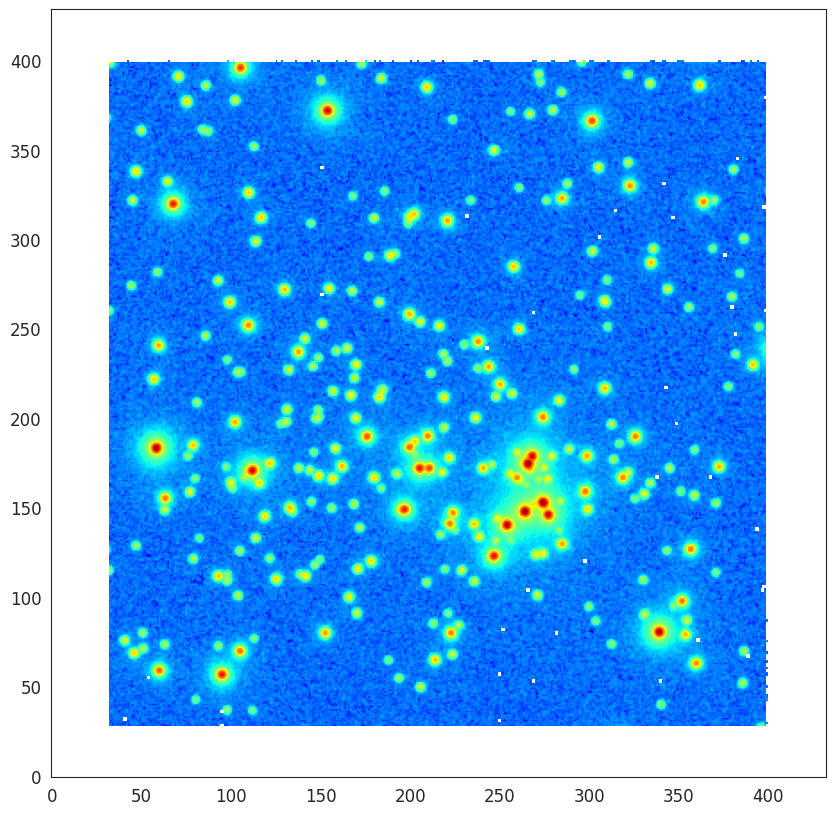

In [134]:
plt.imshow(aligned_images, cmap='jet', norm = col.LogNorm(), origin='lower')